# Vehicle Detection and Tracking

In [1]:
import random
import pickle
import time
import glob

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline

### 1. Preparing Data

In [8]:
# images are divided up into vehicles and non-vehicles
cars = glob.glob('vehicles/**/*.png', recursive=True)
notcars = glob.glob('non-vehicles/**/*.png', recursive=True)
print("car templates: %d " % len(cars))
print("non-car templates: %d " % len(notcars))

car templates: 8792 
non-car templates: 8968 


### 2. Data Look

In [ ]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] =len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    img = mpimg.imread(car_list[0])
    image_shape = img.shape
    data_dict["image_shape"] = image_shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = type(img)
    
    # Return data_dict
    return data_dict

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: <class 'numpy.ndarray'>


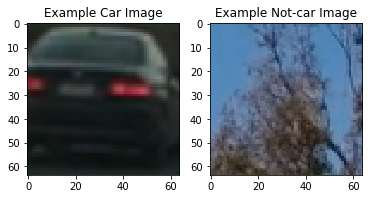

In [3]:
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

### 3. HOG Implementation

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, 
                                  feature_vector=feature_vec)
#                                   block_norm='L1-sqrt')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=18, 
                        pix_per_cell=12, cell_per_block=1, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

### 4. HOG Visualization 

In [15]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
cv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

(60, 106, 1, 1, 18)


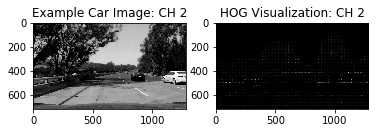

In [171]:
# Define HOG parameters
orient = 18
pix_per_cell = 12
cell_per_block = 1
# channel = 0


# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(cv_image[:,:,0], orient, 
                    pix_per_cell, cell_per_block, 
                    vis=True, feature_vec=False)

print(features.shape)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image[:,:,channel], cmap='gray')
plt.title('Example Car Image: CH %d' % channel)
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization: CH %d' % channel)
#### Display HOG Test 

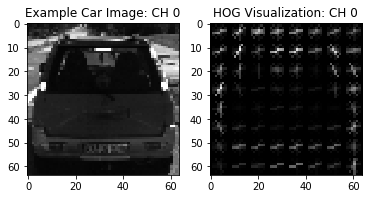

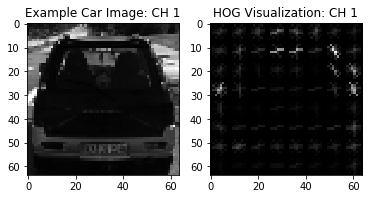

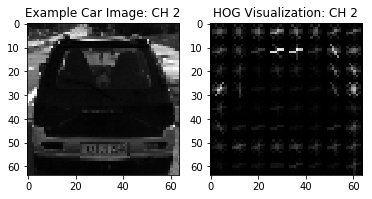

In [16]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
channel = 0

for channel in range(3):
    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(cv_image[:,:,channel], orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(image[:,:,channel], cmap='gray')
    plt.title('Example Car Image: CH %d' % channel)
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization: CH %d' % channel)
    #### Display HOG Test 

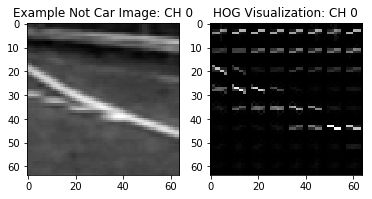

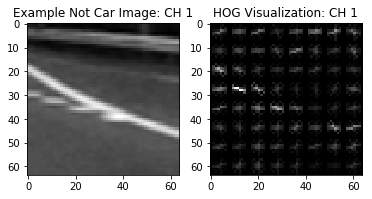

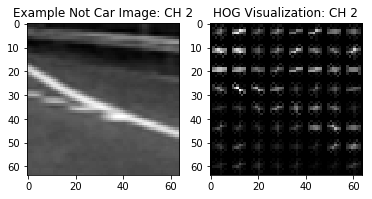

In [17]:
image = mpimg.imread(notcars[ind])
cv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
channel = 0

for channel in range(3):
    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(cv_image[:,:,channel], orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(image[:,:,channel], cmap='gray')
    plt.title('Example Not Car Image: CH %d' % channel)
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization: CH %d' % channel)
    #### Display HOG Test 

### 5. Experiment : Chooseing HOG Perimeter

In [18]:
# Select 1000 sample to reduce feature training time
items = random.sample(range(len(cars)), 1000)
sample_cars = []
sample_notcars = []
for i in items:
    sample_cars.append(cars[i])
    sample_notcars.append(notcars[i])
    
print(len(sample_cars))
print(len(sample_notcars))

1000
1000


In [69]:
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off

cs = ['HSV', 'HLS', 'YCrCb', 'RGB']
ori = [6, 9, 12]
pix_cell = [8, 12]
cell_block = [1, 2,  3]
channel = [0, 1, 2, 'ALL']

for color_space in cs:
    for orient in ori:
        for pix_per_cell in pix_cell:
            for cell_per_block in cell_block:
                for hog_channel in channel:

                    car_features = extract_features(sample_cars, color_space=color_space, 
                                            spatial_size=spatial_size, hist_bins=hist_bins, 
                                            orient=orient, pix_per_cell=pix_per_cell, 
                                            cell_per_block=cell_per_block, 
                                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                            hist_feat=hist_feat, hog_feat=hog_feat)
                    notcar_features = extract_features(sample_notcars, color_space=color_space, 
                                            spatial_size=spatial_size, hist_bins=hist_bins, 
                                            orient=orient, pix_per_cell=pix_per_cell, 
                                            cell_per_block=cell_per_block, 
                                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                            hist_feat=hist_feat, hog_feat=hog_feat)

                    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                    # Fit a per-column scaler
                    X_scaler = StandardScaler().fit(X)
                    # Apply the scaler to X
                    scaled_X = X_scaler.transform(X)

                    # Define the labels vector
                    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


                    # Split up data into randomized training and test sets
                    rand_state = np.random.randint(0, 100)
                    X_train, X_test, y_train, y_test = train_test_split(
                        scaled_X, y, test_size=0.2, random_state=rand_state)

                    print('Using:',color_space, 'color_space')
                    print('Channel:', hog_channel)
                    print('Using:',orient,'orientations',pix_per_cell,
                        'pixels per cell and', cell_per_block,'cells per block')
                    print('Feature vector length:', len(X_train[0]))
                    # Use a linear SVC 
                    svc = LinearSVC()
                    # Check the training time for the SVC
                    t=time.time()
                    svc.fit(X_train, y_train)
                    t2 = time.time()
                    print(round(t2-t, 2), 'Seconds to train SVC...')
                    # Check the score of the SVC
                    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
                    
print('Done')

Using: HSV color_space
Channel: 0
Using: 6 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 384
0.24 Seconds to train SVC...
Test Accuracy of SVC =  0.8275
Using: HSV color_space
Channel: 1
Using: 6 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 384
0.32 Seconds to train SVC...
Test Accuracy of SVC =  0.81
Using: HSV color_space
Channel: 2
Using: 6 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 384
0.19 Seconds to train SVC...
Test Accuracy of SVC =  0.9075
Using: HSV color_space
Channel: ALL
Using: 6 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 1152
0.07 Seconds to train SVC...
Test Accuracy of SVC =  0.9575
Using: HSV color_space
Channel: 0
Using: 6 orientations 8 pixels per cell and 3 cells per block
Feature vector length: 1944
0.85 Seconds to train SVC...
Test Accuracy of SVC =  0.855
Using: HSV color_space
Channel: 1
Using: 6 orientations 8 pixels per cell and 3 cell

#### Parameter Fine Tuning

In [82]:
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off

cs = ['HSV', 'HLS', 'YCrCb']
ori = [ 9, 12, 18]
pix_cell = [12, 15]
cell_block = [1, 2]
channel = 'ALL'

for color_space in cs:
    for orient in ori:
        for pix_per_cell in pix_cell:
            for cell_per_block in cell_block:
            
                car_features = extract_features(sample_cars, color_space=color_space, 
                                        spatial_size=spatial_size, hist_bins=hist_bins, 
                                        orient=orient, pix_per_cell=pix_per_cell, 
                                        cell_per_block=cell_per_block, 
                                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                        hist_feat=hist_feat, hog_feat=hog_feat)
                notcar_features = extract_features(sample_notcars, color_space=color_space, 
                                        spatial_size=spatial_size, hist_bins=hist_bins, 
                                        orient=orient, pix_per_cell=pix_per_cell, 
                                        cell_per_block=cell_per_block, 
                                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                        hist_feat=hist_feat, hog_feat=hog_feat)

                X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                # Fit a per-column scaler
                X_scaler = StandardScaler().fit(X)
                # Apply the scaler to X
                scaled_X = X_scaler.transform(X)

                # Define the labels vector
                y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


                # Split up data into randomized training and test sets
                rand_state = np.random.randint(0, 100)
                X_train, X_test, y_train, y_test = train_test_split(
                    scaled_X, y, test_size=0.2, random_state=rand_state)

                print('Using:',color_space, 'color_space')
                print('Channel:', hog_channel)
                print('Using:',orient,'orientations',pix_per_cell,
                    'pixels per cell and', cell_per_block,'cells per block')
                print('Feature vector length:', len(X_train[0]))
                # Use a linear SVC 
                svc = LinearSVC()
                # Check the training time for the SVC
                t=time.time()
                svc.fit(X_train, y_train)
                t2 = time.time()
                print(round(t2-t, 2), 'Seconds to train SVC...')
                # Check the score of the SVC
                print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
                    
print('Done')

Using: HSV color_space
Channel: ALL
Using: 9 orientations 12 pixels per cell and 1 cells per block
Feature vector length: 675
0.74 Seconds to train SVC...
Test Accuracy of SVC =  0.95
Using: HSV color_space
Channel: ALL
Using: 9 orientations 12 pixels per cell and 2 cells per block
Feature vector length: 1728
0.33 Seconds to train SVC...
Test Accuracy of SVC =  0.965
Using: HSV color_space
Channel: ALL
Using: 9 orientations 15 pixels per cell and 1 cells per block
Feature vector length: 432
0.33 Seconds to train SVC...
Test Accuracy of SVC =  0.95
Using: HSV color_space
Channel: ALL
Using: 9 orientations 15 pixels per cell and 2 cells per block
Feature vector length: 972
0.18 Seconds to train SVC...
Test Accuracy of SVC =  0.965
Using: HSV color_space
Channel: ALL
Using: 12 orientations 12 pixels per cell and 1 cells per block
Feature vector length: 900
0.1 Seconds to train SVC...
Test Accuracy of SVC =  0.965
Using: HSV color_space
Channel: ALL
Using: 12 orientations 12 pixels per cel

### 6. SVC Model Traing 

In [152]:
print("number of cars: ", len(cars))
print("number of nocars: ", len(notcars))

number of cars:  8792
number of nocars:  8968


In [9]:
# Best parameter
color_space = 'YCrCb'
orient = 18
pix_per_cell = 12
cell_per_block = 1
hog_channel = 'ALL'
hog_feat = True

spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',color_space, 'color_space')
print('Channel:', hog_channel)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Using: YCrCb color_space
Channel: ALL
Using: 18 orientations 12 pixels per cell and 1 cells per block
Feature vector length: 1350
5.21 Seconds to train SVC...
Test Accuracy of SVC =  0.9747


#### Store Model

In [7]:
pickle_file = 'svc_model.pkl'
dist_pickle = {
    'svc':svc,
    'scaler':X_scaler,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size': spatial_size,
    'hist_bins': hist_bins
}

with open(pickle_file, 'wb') as s:
    pickle.dump(dist_pickle, s)
print('Linear SVC was saved to ', pickle_file)

Linear SVC was saved to  svc_model.pkl


### 7. Sliding Window

In [3]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#### 7.2 Multi scale window

In [55]:
def multi_scale_window(img):
        
    # image size
    height = img.shape[0]
    width = img.shape[1]
    
#     small size
    x_start_stop = [int(0.2 * width), width]
    y_start_stop = [int(0.5 * height), int(0.8 * height)]
    small = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    
    # medium size
    x_start_stop = [int(0.2 * width), width]
    y_start_stop = [int(0.5 * height), int(0.8 * height)]
    medium = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.8, 0.8))
    
    # large size
    x_start_stop = [int(0.3 * width), width]
    y_start_stop = [int(0.5 * height), int(0.95 * height)]
    large = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.6, 0.6))
    
    # extreme size
    x_start_stop = [int(0.3 * width), width]
    y_start_stop = [int(0.5 * height), 0.95 * height]
    extreme = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(256, 192), xy_overlap=(0.6, 0.5))
    
#     small = []
    small.extend(medium)
    small.extend(large)
#     small.extend(extreme)
    
    return small

0.009318828582763672


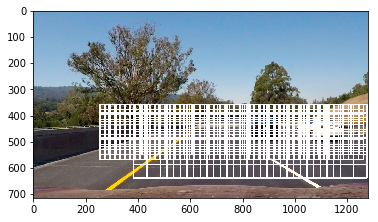

In [56]:
image = mpimg.imread("test_images/test9.png")

t = time.time()
windows = multi_scale_window(image)
t2 = time.time()
print(t2 - t)

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=4)                    
plt.imshow(window_img)

#### 7.3 single image features

In [28]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=18, 
                        pix_per_cell=12, cell_per_block=1, hog_channel='ALL',
                        spatial_feat=False, hist_feat=False, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(3):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))   
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=18, 
                    pix_per_cell=12, cell_per_block=1, 
                    hog_channel='ALL', spatial_feat=False, 
                    hist_feat=False, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []

    #2) Iterate over all windows in the list
    for window in windows:

        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
    
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        
        prediction = clf.predict(test_features)

        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

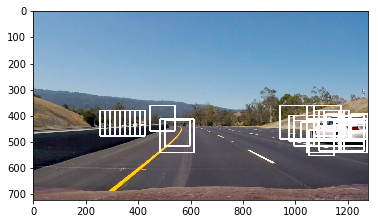

In [65]:
image = mpimg.imread('test_images/test7.png')
# image = mpimg.imread('000185.png')
draw_image = np.copy(image)

windows = multi_scale_window(image)

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 255), thick=6)                    

plt.imshow(window_img)

### 8. Heat map

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

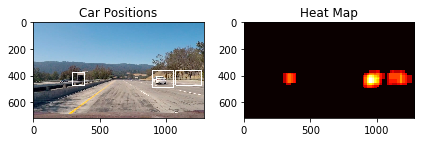

In [78]:
# Read in image similar to one shown above 
image = mpimg.imread('test_images/test8.png')

window = multi_scale_window(image)

box_list = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)     

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)

draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

3 cars found


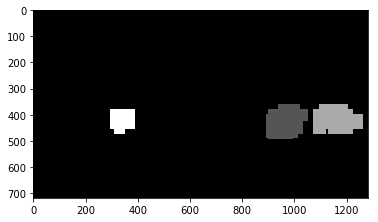

In [79]:
# heatmap = threshold(heatmap, 2)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

In [16]:
def process_image(image):
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    draw_image = np.copy(image)

    windows = multi_scale_window(image)
    
    box_list = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img


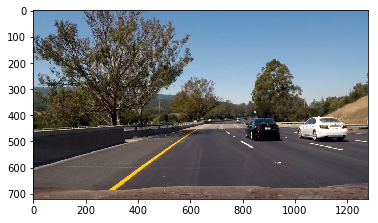

In [63]:
image = mpimg.imread('test_images/test6.jpg')
d_image = process_image(image)
plt.imshow(d_image)

### Process Video

In [147]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [150]:
challenge_output = 'project_video_out.mp4'
clip2 = VideoFileClip('project_video.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video results.mp4
[MoviePy] Writing video results.mp4



100%|█████████▉| 1260/1261 [19:25<00:00,  1.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results.mp4 

CPU times: user 19min 23s, sys: 1.39 s, total: 19min 25s
Wall time: 19min 25s


In [151]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('results.mp4'))